In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import h5py
import numpy as np
import pandas as pd
import logging
import re
from scipy.stats import pearsonr

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(format='[%(asctime)s - %(name)s] %(message)s',
                        datefmt='%H:%M:%S',
                        level=logging.DEBUG,
                        handlers=[logging.StreamHandler()])

# Import run settings

In [3]:
def import_gdrive_sheet(gdrive_key, sheet_id):
    run_spreadsheet = pd.read_csv("https://docs.google.com/spreadsheet/ccc?key=" + \
                                  gdrive_key + "&output=csv&gid=" + sheet_id)
    if "date" in run_spreadsheet.columns:
        run_spreadsheet["date"] = run_spreadsheet["date"].astype(str)
    return run_spreadsheet

gdrive_key = "gsheet_id_here"
sheet_id = "0"
set_sheet_id = "512509543"

run_spreadsheet = import_gdrive_sheet(gdrive_key, sheet_id)
set_spreadsheet = import_gdrive_sheet(gdrive_key, set_sheet_id)

# Import training data

In [4]:
training_run_names = ["08_09_2019_run_01",
                      "08_13_2019_run_02",
                      "08_13_2019_run_03",
                      "08_15_2019_run_02",
                      "08_15_2019_run_03",
                      "08_16_2019_run_01",]

In [5]:
training_runs = run_spreadsheet[run_spreadsheet["run_name"].apply(lambda x: x in training_run_names)]

In [11]:
train_sw = []
for i, run_data in training_runs.iterrows():
    run_name = run_data["run_name"]
    label_file = run_data["filtered_sw_labels"]
    
    sw = pd.read_csv(label_file, sep="\t", index_col=0)
    sw["run_name"] = run_name
    train_sw.append(sw)
train_sw = pd.concat(train_sw)

# Import test sets

In [12]:
test_run_names = ["08_28_2019_run_01",
                  "08_30_2019_run_01",]

In [13]:
test_runs = run_spreadsheet[run_spreadsheet["run_name"].apply(lambda x: x in test_run_names)]

In [26]:
test_sw = []
test_cnn = []
for i, run_data in test_runs.iterrows():
    run_name = run_data["run_name"]
    sw_label_file = run_data["filtered_sw_labels"]
    
    sw = pd.read_csv(sw_label_file, sep="\t", index_col=0)
    sw["run_name"] = run_name
    test_sw.append(sw)
    
    cnn_label_file = run_data["model_v4_0_1_labeled_preds"]
test_sw = pd.concat(test_sw)

# Get train and test read counts

In [27]:
train_molbit_counts = []
train_norms = []
norm_train_molbit_counts = []
train_bits = []
for set_i, start_molbit in enumerate(range(0, 96, 16)):
    run_data = dict(training_runs[training_runs["molbit_set"] == set_i].iloc[0, :])
    run_name = run_data["run_name"]
        
    for half in [0, 1]:
        if half == 0:
            molbits_in_range = range(start_molbit, start_molbit+8)
        else:
            molbits_in_range = range(start_molbit+8, start_molbit+16)

        labels_from_run = train_sw[train_sw["run_name"] == run_name]
        filtered_labels_in_run = labels_from_run[labels_from_run["molbit"].apply(lambda x: x in molbits_in_range)]
        l, c = np.unique(filtered_labels_in_run["molbit"], return_counts=True)
        for l_, c_ in zip(l, c):
            train_molbit_counts.append(c_)
            norm_train_molbit_counts.append(c_ / sum(c))
        train_norms.append(sum(c))
        train_bits.append(molbits_in_range)

In [28]:
test_molbit_counts = []
test_norms = []
norm_test_molbit_counts = []
test_bits = []
for set_i, start_molbit in enumerate(range(0, 96, 16)):
    for half in [0, 1]:
        if half == 0:
            run_name = test_run_names[0]
            molbits_in_range = range(start_molbit, start_molbit+8)
        else:
            run_name = test_run_names[1]
            molbits_in_range = range(start_molbit+8, start_molbit+16)
        test_sw_run = test_sw[test_sw["run_name"] == run_name]
        filtered_labels_in_run = test_sw_run[test_sw_run["molbit"].apply(lambda x: x in molbits_in_range)]
        l, c = np.unique(filtered_labels_in_run["molbit"], return_counts=True)
        for l_, c_ in zip(l, c):
            test_molbit_counts.append(c_)
            norm_test_molbit_counts.append(c_ / sum(c))
        test_norms.append(sum(c))
        test_bits.append(molbits_in_range)
    

In [29]:
def plot_read_counts_mod(labels, counts,
                     possible_labels=None, ax=None, vmax=None, title_note=None):
    from matplotlib.patches import Patch
    if vmax is None:
        vmax = max(counts) + max(counts)
    if ax == None:
        fig, ax = plt.subplots(figsize=(34, 8))
    if possible_labels is None:
        possible_labels = labels[:]
    g = sns.barplot(x=labels, y=counts, order=possible_labels, ax=ax)
    title = "#/reads identified per barcode"
    if title_note is not None:
        title += "\n(%s)" % title_note
    ax.set_title(title)
    ax.set_xlabel("Barcode ID")
    ax.set_ylabel("Read counts")
    ax.set_ylim([0, vmax])
    
    prev_text_height = 0
    for j, label in enumerate(possible_labels):
        if label in labels:
            count = counts[labels.index(label)]
        else:
            count = 0
        if label == "-1":
            continue

#         if label in labels_in_run:
#             g.containers[0].get_children()[j].set_facecolor("tab:red")
#             font_kwargs = {"color": "tab:red", "weight": "bold"} 
#         elif label in labels_on_flowcell:
#             g.containers[0].get_children()[j].set_facecolor("tab:blue")
#             font_kwargs = {"color": "k", "weight": "bold"}
#         else:
        g.containers[0].get_children()[j].set_facecolor("k")
        font_kwargs = {"color": "k", "weight": "normal"}
            
        diff = prev_text_height - (count + 0.01 * vmax)
        if int(count) == count:
            count_fmt = f"{count}"
        else:
            count_fmt = f"{count:.3f}"
        if count < 100:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count_fmt, ha="center", **font_kwargs)
        elif diff < 0 and np.abs(diff) < vmax * .06:
            text_height = np.max([prev_text_height + .035 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count_fmt, ha="center", **font_kwargs)
        elif np.abs(diff) < vmax * .05:
            text_height = np.min([prev_text_height - .01 * vmax, count + .01 * vmax])
            ax.text(j, text_height, count_fmt, ha="center", **font_kwargs)
        else:
            text_height = count + .01 * vmax
            ax.text(j, text_height, count_fmt, ha="center", **font_kwargs)
        prev_text_height = text_height
        
#     legend_elements = [Patch(facecolor='k', edgecolor='k',
#                          label='never been run on this flowcell'),
#                        Patch(facecolor='tab:blue', edgecolor='tab:blue',
#                          label='prev run on flowcell'),
#                        Patch(facecolor='tab:red', edgecolor='tab:red',
#                          label='current run on flowcell')]
#     leg = ax.legend(handles=legend_elements)
#     t1, t2, t3 = leg.get_texts()
#     t2._fontproperties = t1._fontproperties.copy()
#     t3._fontproperties = t1._fontproperties.copy()
#     t2.set_weight('bold')
#     t3.set_weight('bold')
#     t3.set_color("tab:red")
    return ax

(0, 40000)

[17:09:31 - matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.5.
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 3.335
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
[17:09:31 - matplotlib.fo

[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-ExtraLight.otf) normal normal light normal>) = 10.24
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Lohit Gujarati' (Lohit-Gujarati.ttf) normal normal 400 normal>) = 10.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS75F.ttf) normal normal bold normal>) = 10.335
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'PakType Naqsh' (PakType_Naqsh.ttf) normal normal 400 normal>) = 10.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'FreeMono' (FreeMonoBold.ttf) normal normal bold normal>) = 10.335
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Medium.otf) normal normal medium normal>) = 10.145
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Bol

[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Lohit Assamese' (Lohit-Assamese.ttf) normal normal 400 normal>) = 10.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'VL Gothic' (VL-Gothic-Regular.ttf) normal normal regular normal>) = 10.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal 400 normal>) = 10.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Carlito' (Carlito-Regular.ttf) normal normal 400 normal>) = 10.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.ttf) normal normal light normal>) = 2.24
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal bold normal>) = 11.335
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'STIX' (STIX-Regular.otf) normal normal regular normal>) = 10.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Lohit Oriya' (Lohit-

[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'PT Sans Narrow' (PTN57F.ttf) normal normal 400 condensed>) = 10.25
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans CN' (SourceHanSansCN-Light.otf) normal normal light normal>) = 10.24
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Khmer OS Content' (KhmerOS_content.ttf) normal normal 400 normal>) = 10.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS76F.ttf) italic normal bold normal>) = 11.335
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS56F.ttf) italic normal 400 normal>) = 11.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Caladea' (Caladea-Italic.ttf) italic normal 400 normal>) = 11.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-BoldOblique.otf) oblique nor

[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Bold.ttf) normal normal bold normal>) = 4.335
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Source Han Sans TWHK' (SourceHanSansTWHK-Light.otf) normal normal light normal>) = 10.24
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal bold normal>) = 11.335
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Cantarell' (Cantarell-Bold.otf) normal normal bold normal>) = 10.335
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'Liberation Sans' (LiberationSans-Regular.ttf) normal normal 400 normal>) = 4.05
[17:09:31 - matplotlib.font_manager] findfont: score(<Font 'NanumGothic' (NanumGothicExtraBold.ttf) normal normal bold normal>) = 10.335
[17:09:31 - matplotlib.font_manager] 

[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal bold normal>) = 2.335
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>

[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree.ttf) normal normal 400 normal>) = 10.05
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'Waree' (Waree-Bold.ttf) normal normal bold normal>) = 10.335
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'FreeSans' (FreeSansBoldOblique.ttf) oblique normal bold normal>) = 11.335
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'FreeMono' (FreeMono.ttf) normal normal 400 normal>) = 10.05
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'Noto Sans Tagalog' (NotoSansTagalog-Regular.ttf) normal normal 400 normal>) = 10.05
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'Lohit Tamil' (Lohit-Tamil.ttf) normal normal 400 normal>) = 10.05
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) = 11.25
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'Caladea' (Caladea-BoldItalic.ttf) i

[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'FreeSerif' (FreeSerifBold.ttf) normal normal bold normal>) = 10.335
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'PT Sans Narrow' (PTN77F.ttf) normal normal bold condensed>) = 10.535
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'PT Sans' (PTS55F.ttf) normal normal 400 normal>) = 10.05
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'Padauk' (Padauk-bold.ttf) normal normal bold normal>) = 10.335
[17:09:32 - matplotlib.font_manager] findfont: score(<Font 'Lohit Kannada' (Lohit-Kannada.ttf) normal normal 400 normal>) = 10.05
[17:09:32 - matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/ssd1/home/kdorosch/software/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 2.050000.


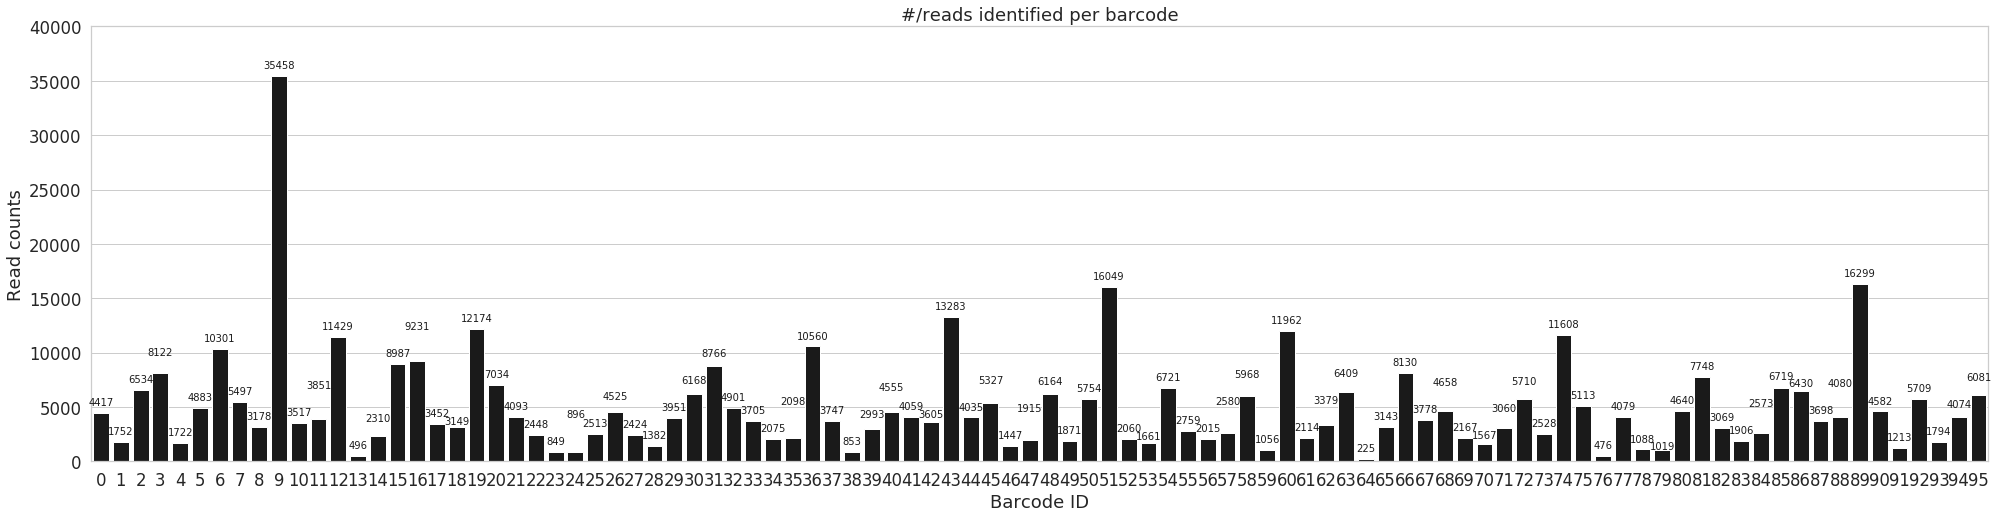

In [30]:
ax = plot_read_counts_mod([str(x) for x in range(96)], test_molbit_counts, possible_labels=[str(x) for x in range(96)])
ax.set_ylim([0, 40000])

(0, 0.6)

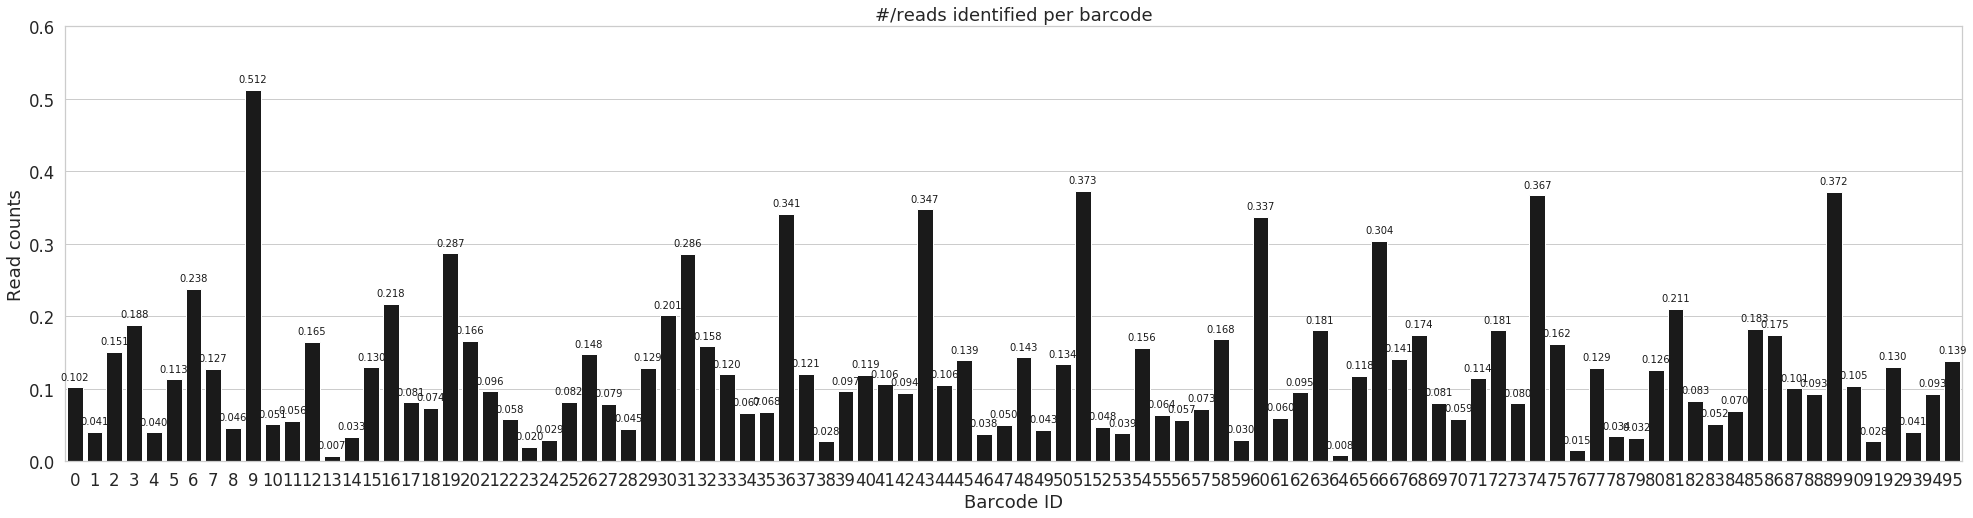

In [31]:
ax = plot_read_counts_mod([str(x) for x in range(96)], norm_test_molbit_counts, possible_labels=[str(x) for x in range(96)])
ax.set_ylim([0, 0.6])

# Combine read counts from the two test runs and re-normalize

In [32]:
norm_counts_test = np.array(norm_test_molbit_counts) / sum(norm_test_molbit_counts)

(0, 0.05)

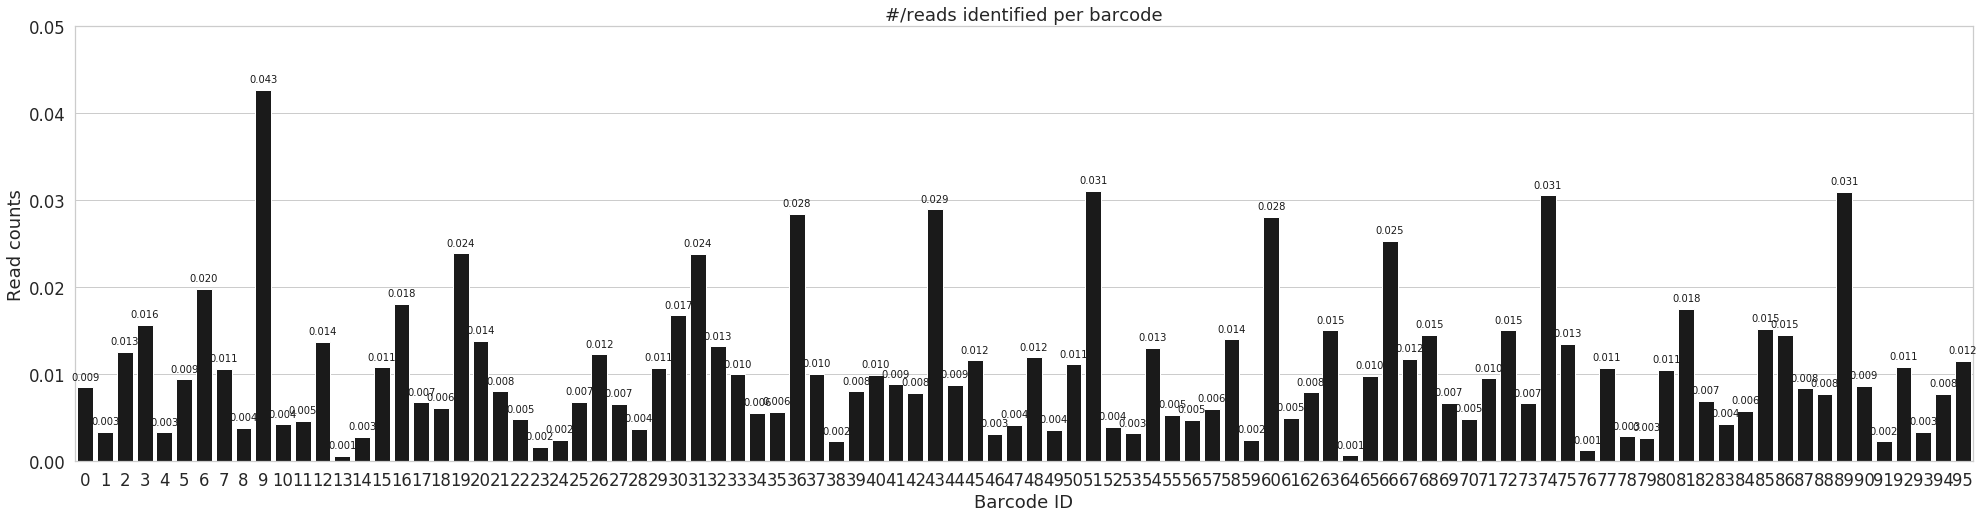

In [33]:
ax = plot_read_counts_mod([str(x) for x in range(96)], norm_counts_test, possible_labels=[str(x) for x in range(96)])
ax.set_ylim([0, 0.05])

In [34]:
scaling_factor = 1 / norm_counts_test

In [35]:
scaled_test_counts = [int(scale * count) for scale, count in zip(scaling_factor, test_molbit_counts)] / (sum(test_molbit_counts))

(0, 10)

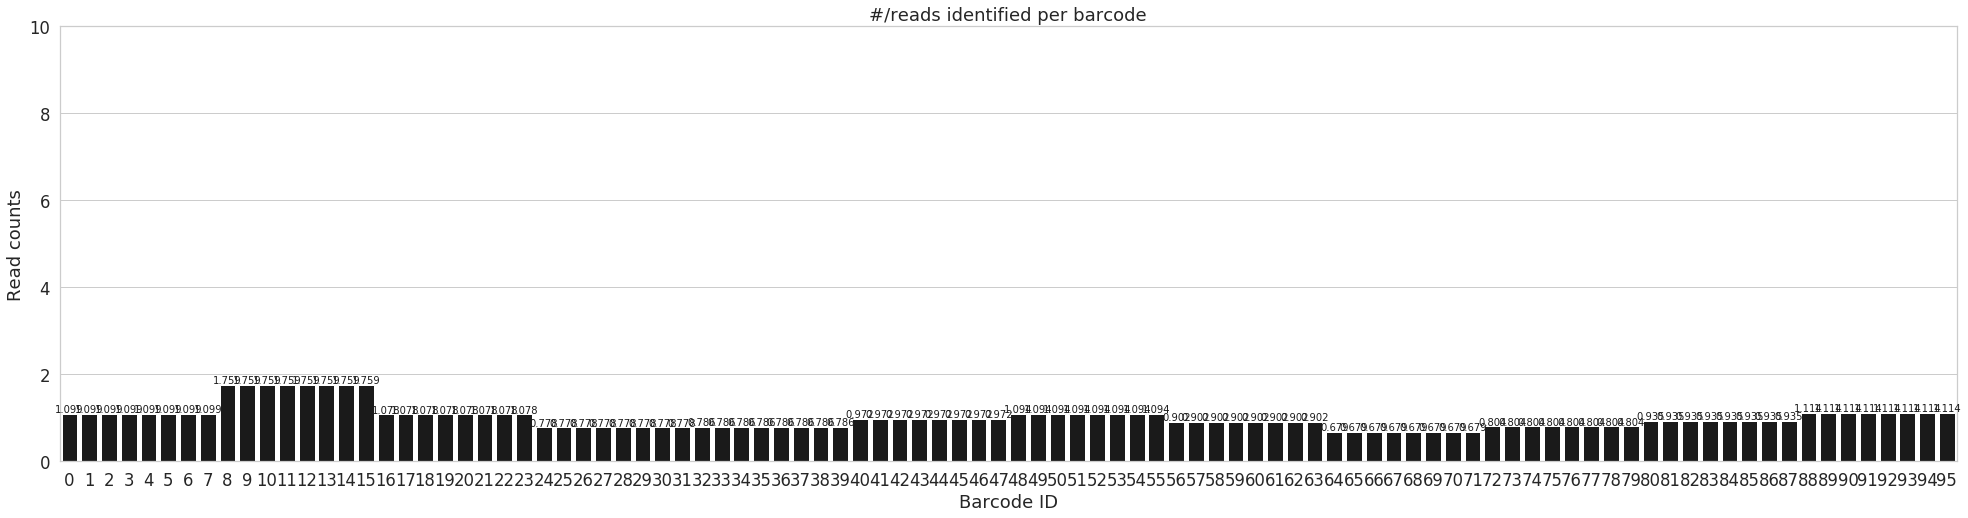

In [36]:
ax = plot_read_counts_mod([str(x) for x in range(96)], scaled_test_counts, possible_labels=[str(x) for x in range(96)])
ax.set_ylim([0, 10])

In [37]:
scaled_train_counts = [int(scale * count) for scale, count in zip(scaling_factor, train_molbit_counts)] / sum(train_molbit_counts)

(0, 4)

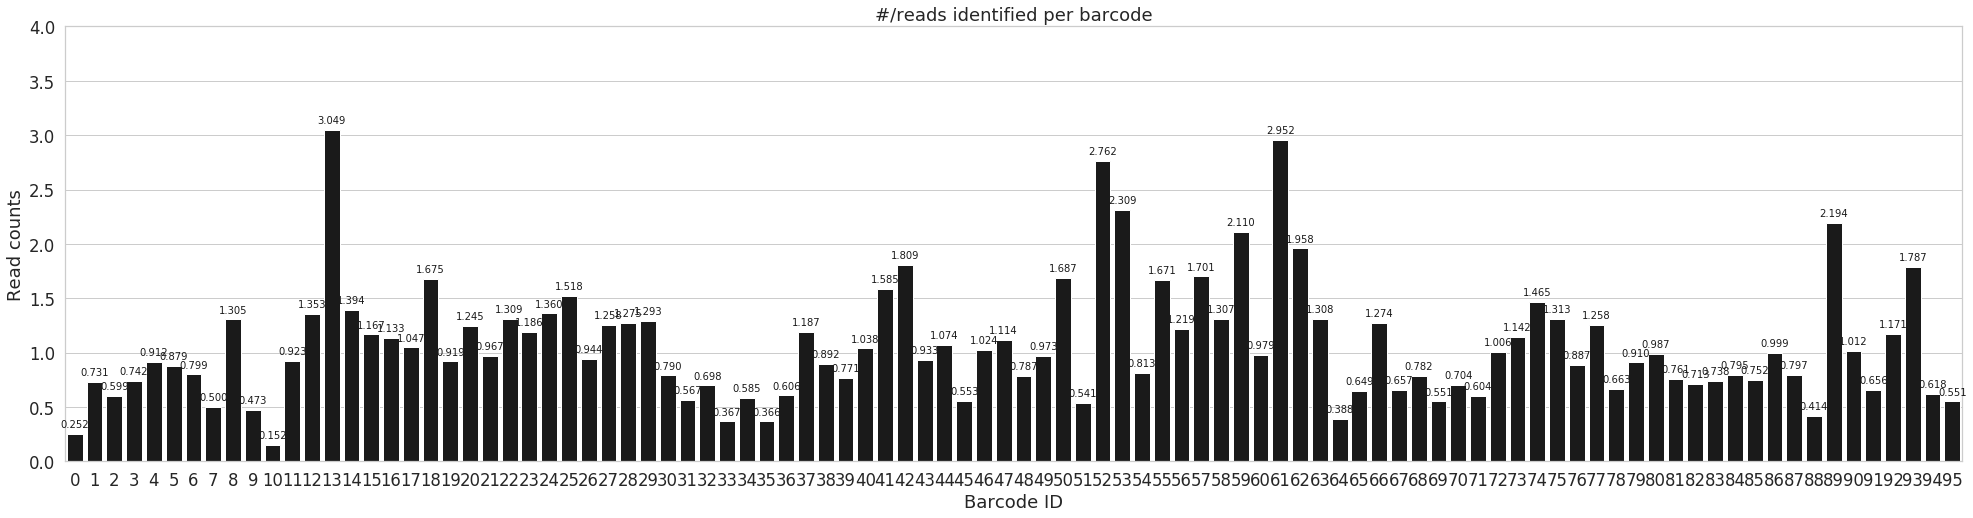

In [38]:
ax = plot_read_counts_mod([str(x) for x in range(96)], scaled_train_counts, possible_labels=[str(x) for x in range(96)])
ax.set_ylim([0, 4])

(0, 76000)

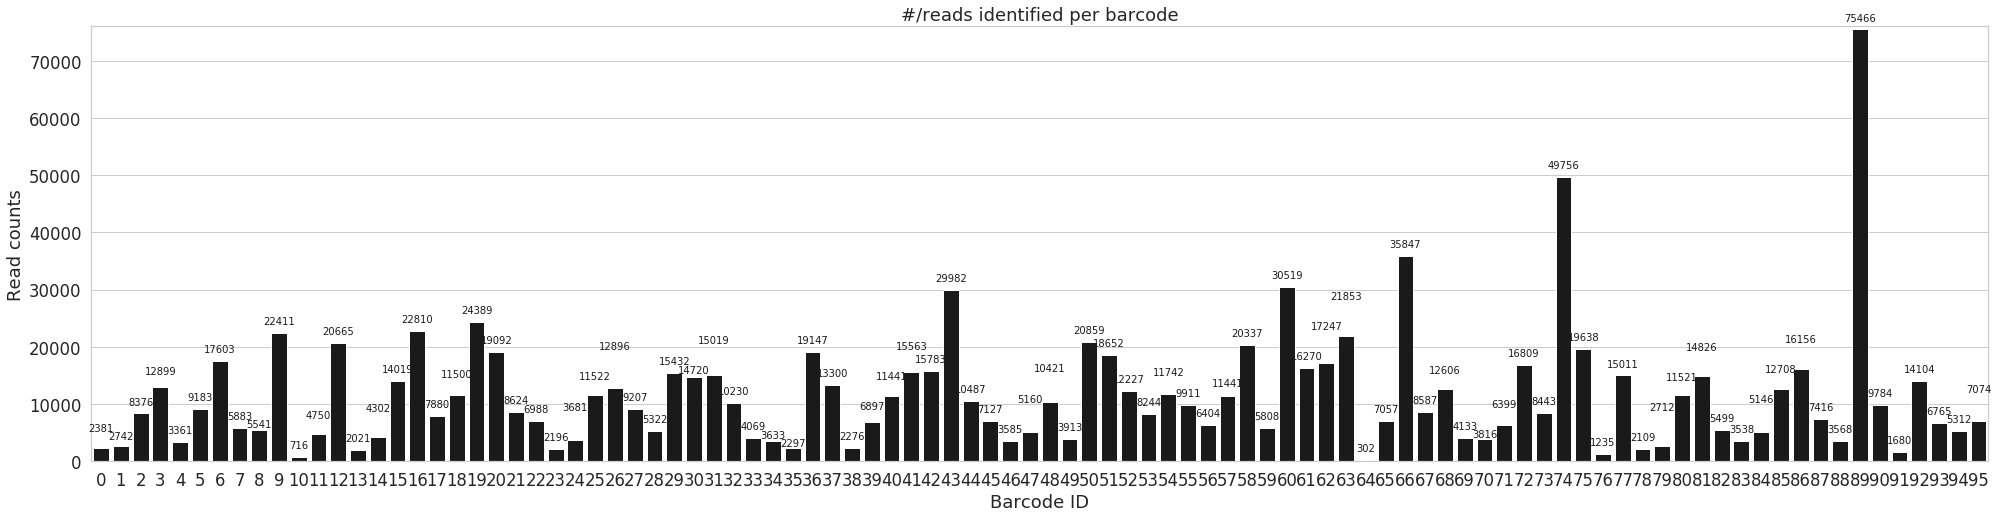

In [39]:
ax = plot_read_counts_mod([str(x) for x in range(96)], train_molbit_counts, possible_labels=[str(x) for x in range(96)])
ax.set_ylim([0, 76000])

In [41]:
scaling_factor

array([ 117.44079692,  296.08219178,   79.3902663 ,   63.8680128 ,
        301.24041812,  106.23305345,   50.35782934,   94.36710933,
        261.39458779,   23.42805573,  236.19903327,  215.71332122,
         72.68457433, 1674.82258065,  359.61558442,   92.43485034,
         55.15762106,  147.49710313,  161.68942521,   41.8235584 ,
         72.38555587,  124.39775226,  207.99019608,  599.71731449,
        410.15625   ,  146.23955432,   81.21546961,  151.60891089,
        265.91895803,   93.01442673,   59.58171206,   41.92334018,
         75.73638033,  100.18461538,  178.88385542,  176.9227836 ,
         35.15      ,   99.06164932,  435.15123095,  124.01737387,
        100.70515917,  113.01108647,  127.24327323,   34.53376496,
        113.68327138,   86.11075652,  317.00898411,  239.53629243,
         83.78780013,  276.0384821 ,   89.75808133,   32.18069662,
        250.71262136,  310.93798916,   76.84392204,  187.19391084,
        211.31315136,  165.0372093 ,   71.34651475,  403.21590